# Quantum state Tomography
#### Team #15
- Alexandr Talitsky
- Andrey Vlasov
- Anton Bozhedarov
- Nikolay Shvetsov
- Polina Pilyugina


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
%matplotlib inline

## Simulate experiment 
In this part we:
- generate state of qubit
- define experimental setup (i.e. how we should measure the qubit and how many copies of it we have)
- model experiment (obtain frequency probabilities outcomes)

In [2]:
# define how we will measure the system
def protocol(case = 'tetr', n = 1):
    """
    return matrix of measurement protocol, where
       row - measurement operator
       column - operator's coefficients
    case: 'tetr', 'xyz'
    n: number of qubits (int)
    """
    if case == 'tetr':
        sq3 = 1/np.sqrt(3)
        a0 = np.array([1,sq3,sq3,sq3])
        a1 = np.array([1,sq3,-sq3,-sq3])
        a2 = np.array([1,-sq3,sq3,-sq3])
        a3 = np.array([1,-sq3,-sq3,sq3])
        A = np.array([a0,a1,a2,a3])
        S = A
        for i in range(n-1):
            S = np.kron(S,A)
        S = S/S.shape[0]
    
    if case == 'xyz':
        x = np.array([1,1,0,0])
        y = np.array([1,0,1,0])
        z = np.array([1,0,0,1])
        A = [x,-x,y,-y,z,-z]
        S = A
        for i in range(n-1):
            S = np.kron(S, A)
        S = S/S.shape[0]
             
    return S

In [3]:
# model experiment's outcome
def measurements(E, rho, N = 1000, noise = 0):
    """
    returns frequency probabilies for measurements of state rho according to protocol E
    E - (nd.array)
    rho - state as expanded vector on Bloch sphere
    N - number of measurements (int)
    noise - level of noise while measurements (from 0 to 1)
    """
    if (noise > 1) or (noise < 0):
        print("incorrect level of noise")
        return False
    p = E@rho
    n = np.zeros(E.shape[0])
    pos_outcomes = np.arange(E.shape[0])
    
    outcomes = np.random.choice(pos_outcomes, size = N, p = p)
    
    if noise > 0:
        # level of noise
        noise_pos = np.random.choice([0,1], p = [1-noise, noise], size=N)
#         replace = np.random.choice(range(N), replace=False, size= int(N*noise) )
        outcomes[np.where(noise_pos == 1)] = np.random.choice(pos_outcomes, size = np.sum(noise_pos))
        
    beta = 0.5
    
    for i in range(E.shape[0]):
        ind = np.where(outcomes == pos_outcomes[i])
        n[i] = (len(ind[0])+beta)/(N+2*beta)
        
    return n

In [4]:
def gen_state(n = 1):
    """
    returns random state of n qubits
    """
    
    def rand_qubit():
        """
        returns random state of single qubit
        """
        fi = np.random.uniform(0, 2*np.pi)
        theta = np.arccos( np.random.uniform(-1., 1.) )
        x = np.cos(fi) * np.sin(theta)
        y = np.sin(fi) * np.sin(theta)
        z = np.cos(theta)
#         return np.array([1,0,0,1])
        return np.array([1,x,y,z])
        
    state = rand_qubit()   
    for i in range(n-1):
        state = np.kron(state, rand_qubit())
    
    return state

In [5]:
def pauli_dot(vector):
    """
    Scalar product of matrices Pauli and vector (to return ro matrix representation)
    """ 
    # Pauli matrixes
    X = np.matrix([[0, 1], [1, 0]], dtype = complex)
    Y = np.matrix([[0, -1j], [1j, 0]], dtype = complex)
    Z = np.matrix([[1, 0], [0, -1]], dtype = complex)
    I2 = np.eye(2)
    s = np.array([I2,X,Y,Z])
    S = s
    
    # define number of qubits:
    k = int(np.log2(np.sqrt(len(vector))))
    
    for i in range(n-1):
        S =  np.kron(S,s)
        
    rho = S[0]*vector[0]/(2**k)
    for i in range(1,len(S)):
        rho = rho + 0.5 * S[i] * vector[i]
    
    return rho

For error measurement we will use the following three norms:
* Hilbert-Schmidt 
$$
    \Delta^{HS}(\rho',\, \rho) = \frac{1}{\sqrt{2}}\mathrm{Tr} [\,(\rho' - \rho)^2\,]^{1/2}
$$
* Trace-distance
$$
    \Delta^{T}(\rho',\, \rho) = \frac{1}{2}\mathrm{Tr}[\,|\rho' - \rho|\,]
$$
* Infidelity
$$
    \Delta^{IF}(\rho',\, \rho) = 1-\mathrm{Tr}\Big[\,\sqrt{\sqrt{\rho'}\rho\sqrt{\rho'}}\,\Big]^2
$$

In [6]:
from scipy.linalg import sqrtm
from numpy.linalg import matrix_power

def hs_norm(rho_est, rho):
    return np.real((1/np.sqrt(2))*np.trace(sqrtm(matrix_power(rho_est - rho, 2))))

# def hs_norm(rho_est, rho):
#     return np.real(np.trace(matrix_power(rho_est - rho, 2)))

def t_norm(rho_est, rho):
    M = np.matrix(rho_est - rho)
    return np.real(0.5 * np.trace(sqrtm(M.H@M)))

def if_norm(rho_est, rho):
    sq = sqrtm(rho_est)
    mult = sqrtm(sq @ rho @ sq)
    return np.real((1-np.trace(matrix_power(mult, 2))))

Generate initial state as a vector $\rho_{vec} \in (\mathbb{R}^4)^{\otimes n}$, where $\rho_{vec}$[0] is always 1 (just convinient way of representation).

And then model experiment

In [7]:
n = 1 # number of qubits

E = protocol('tetr', n)

rho_vec = gen_state(n = n) # random state of system of n qubits

N = 1000 # number of measurements (i.e. numer of copies of a system)

b = measurements(E, rho_vec, N = N, noise=0.05) # here we obtain probabilities of measurement outcomes
# print(b)

## Recovery of the state

#### Important note:

After obtainig the result of the tomography we should check whether our solution is physical, i.e.
- $\rho_{est} = \rho_{est}*$ (* means hermitian conjugation)
- $\rho_{est} \ge 0$
- $tr[\rho_{est}] \le 1$

Otherwise we have to find the nearest state $\hat{\rho_{est}}$ that is physical in mentioned conditions

In [8]:
def check_physical(rho):
    '''
    Input: matrix rho
    Output: matrix rho, modified to be phisical
    '''            
    # Positive semi-definiteness
    eigenvalues, s = LA.eigh(rho)

    for i in range(eigenvalues.shape[0]):
        value = eigenvalues[i]
#         print(value)
        if eigenvalues[i] < 0:
            eigenvalues[i] = 0
    rho_modified = np.matmul(np.matmul(s, np.diag(eigenvalues)), LA.inv(s))

    
    # Trace adjustment
    tr = np.trace(rho_modified)
    if tr > 1:
        rho_modified = rho_modified/tr
    return rho_modified

### Likelihood method

One possible method for obtaining the needed estimates is using maximum likelihood estimator. However, after careful examination of recent works on this topic, it was found that the proposed by Robin Blume-Kohout *hedged likelihood functional* (HML) allows more careful extimation, than the use of common likelihood function. <br>
As was suggested by Robin Blume-Kohout, the HML method results in full-rank estimator, so that the problem of mistakenly obtained zero eigenvalues is reduced. Also, HML estimator allows for examination of not only the peak (as in likelihood), but also the victimity of maximum.<br>
That is why in our work we will focus on maximization of convex HML functional, defined as follows:
$$
    \mathcal{L}_H(\{n_j\};\rho)= (\mathrm{det}\,\rho)^\beta\,\mathcal{L}(\{n_j\};\rho)
$$Where $\mathcal{L}(\{n_j\};\rho) = {\displaystyle \prod_{j}p_j^{n_j}}$ and probabilities $p_j = \mathrm{tr}\{\rho\,\Pi_j\}$<br>
In order to search for HML maximum, the following iteration method is used:
1. We start from an arbitrary state, usually $\rho_0 = 1/D$, where $D$ is identity matrix multiplied by dimension of Hilbert space.
2. Follow the direction of the steepest gradient.
3. Look for the extremal state extimator $\hat{\rho}_{HML}$ with the following iterative equations:
$$
    \rho_{k+1} = \frac{[\,1+\Delta_k\,]\rho_k[\,1+\Delta_k\,]} {\mathrm{tr}\{[\,1+\Delta_k\,]\rho_k[\,1+\Delta_k\,]\}}, \\
    \Delta_k = \frac{\epsilon}{2} [\,\beta(\rho_k^{-1} - D) + N(R_k - 1 ) \,]
$$and by the experience of several authors, working on the issue, the best choices for constants are: $\beta = \frac{1}{2}, \epsilon = \frac{1}{N}$

In [9]:
def operator_from_vec(vec):
    vec = np.array(vec).reshape(-1)
    X = np.matrix([[0, 1], [1, 0]], dtype = complex)
    Y = np.matrix([[0, -1j], [1j, 0]], dtype = complex)
    Z = np.matrix([[1, 0], [0, -1]], dtype = complex)
    I2 = np.eye(2)
    s = np.array([I2,X,Y,Z])
    S = s

    # define number of qubits:
    k = int(np.log2(np.sqrt(len(vec))))
    
    for i in range(k-1):
        S =  np.kron(S,s)
        
#     rho = S[0]*vector[0]/(2**k)
    opert = np.zeros(S[0].shape)
    for i in range(S.shape[0]):
        opert = opert + S[i] * vec[i]
    
    return opert

In [10]:
f=b
rho = pauli_dot(rho_vec)
S = np.matrix(protocol())
def R(rho):
    S0 = operator_from_vec(S[0])
    p0 = np.trace(S0 @ rho)
    r = S0 * f[0]/p0
    for j in range(1,E.shape[0]):
        Sj = operator_from_vec(S[j])
        pj =  np.trace(Sj@rho)
        r = r + (Sj * f[j]/pj)
    return r
R(rho)


array([[1.00007248+0.j        , 0.00171394+0.00264097j],
       [0.00171394-0.00264097j, 1.0654168 +0.j        ]])

Lets calculate $\rho_k$ and build convergence in differents norm

In [11]:
n=1
def hml_iteration(S, rho_initial, f, rho_orig, norm, eps = 1/N, beta = 0.5):
        
    def R(rho):
        S0 = operator_from_vec(S[0])
        p0 = np.trace(S0 @ rho)
        r = S0 * f[0]/p0
        for j in range(1,E.shape[0]):
            Sj = operator_from_vec(S[j])
            pj =  np.trace(Sj@rho)
            r = r + (Sj * f[j]/pj)
        return r
    
    def delta_k(rho):
        dk = (eps/2)*( beta*(LA.pinv(rho) - 2*np.eye(2)) + N *(R(rho) - np.eye(2))  )
        return dk
    
    rho_k = rho_initial
    history=[]
    convergence = []
    for k in range(1000):
        m = (np.eye(2) + delta_k(rho_k))
        numer = m @ rho_k @ m
        rho_new = numer/np.trace(numer)
        history.append(rho_k)
        convergence.append(norm(rho_new, rho_k))
        rho_k=rho_new
        
    return rho_k, convergence
    
rho_k, convergence_hs =hml_iteration(S, np.eye(2), b, rho, hs_norm)
_, convergence_t =hml_iteration(S, np.eye(2), b, rho, t_norm)
_, convergence_if =hml_iteration(S, np.eye(2), b, rho, if_norm)

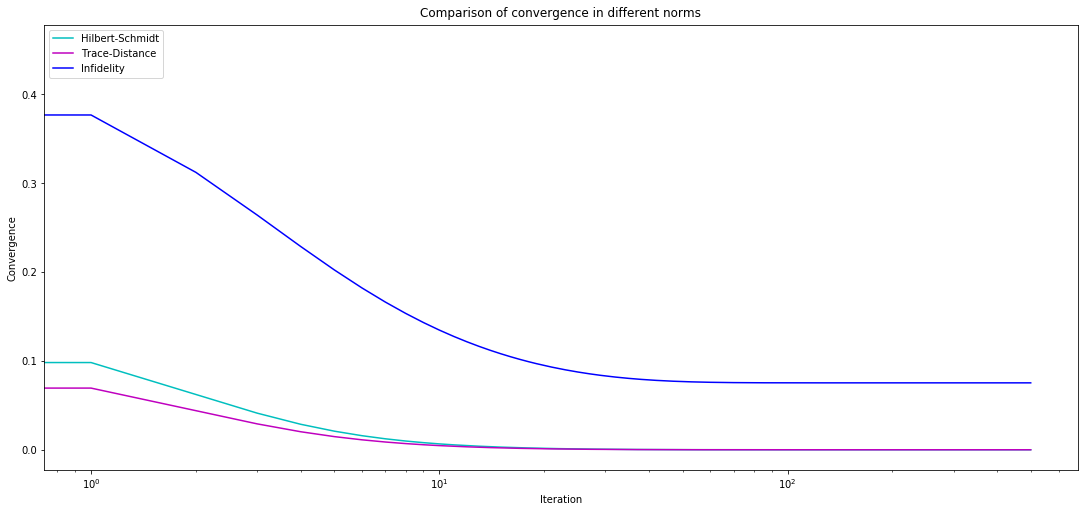

In [12]:
plt.figure(figsize=(15,7), constrained_layout=True) 
plt.title('Comparison of convergence in different norms', pad=8)
plt.xlabel('Iteration')
plt.ylabel('Convergence')
plt.semilogx(range(500), convergence_hs[1:501], c='c', label='Hilbert-Schmidt')
plt.semilogx(range(500), convergence_t[1:501], c='m', label='Trace-Distance')
plt.semilogx(range(500), convergence_if[1:501], c='b', label='Infidelity')
plt.legend(loc='upper left')

In [13]:
n=1
def hml_iteration(S, rho_initial, f):
    eps = 1/N
    beta = 0.5
    def R(rho):
        S0 = operator_from_vec(S[0])
        p0 = np.trace(S0 @ rho)
        r = S0 * f[0]/p0
        for j in range(1,E.shape[0]):
            Sj = operator_from_vec(S[j])
            pj =  np.trace(Sj@rho)
            r = r + (Sj * f[j]/pj)
        return r
    
    def delta_k(rho):
        dk = (eps/2)*( beta*(LA.pinv(rho) - 2*np.eye(2)) + N *(R(rho) - np.eye(2))  )
        return dk
    
    rho_k = rho_initial
    history = []
    history.append(rho_k)
    for k in range(1000):
        m = (np.eye(2) + delta_k(rho_k))
        numer = m @ rho_k @ m
        rho_k = numer/np.trace(numer)
        history.append(rho_k)
        
    return rho_k
   


Now let's check our $\rho_k$ with $\rho$ and see their diferents, here we can see that our $\rho_k$ is very close to $\rho$, and it is mean that method work good

In [14]:
print(rho)

[[ 0.99159132+0.j        -0.0252263 +0.0877588j]
 [-0.0252263 -0.0877588j  0.00840868+0.j       ]]


In [15]:
rho_k=hml_iteration(S, np.eye(2), b)
print(rho_k)

[[ 0.9515596 +2.09238147e-18j -0.01861138+8.99463540e-02j]
 [-0.01861138-8.99463540e-02j  0.0484404 -2.09238147e-18j]]


Now lets build rellative error according to the differents norms, with different noise level

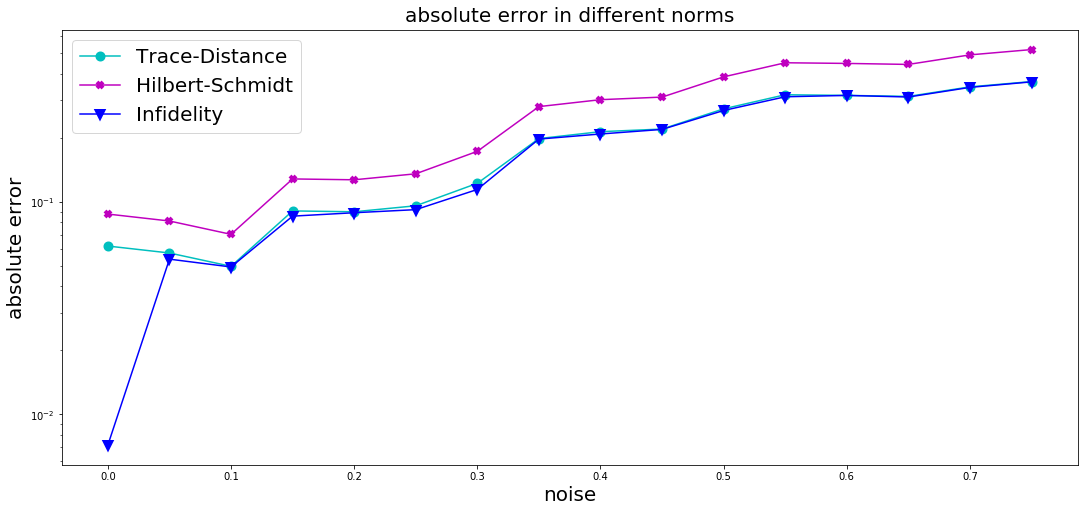

In [16]:
from pylab import rcParams
#Noise detection
#rcParams['figure.figsize'] = 3, 6
rho_vec = gen_state(n = 1) # random state of system of 1 qubit
rho_true = pauli_dot(rho_vec)
snr = np.arange(0,0.8,0.05) # noise level
N = 1000
norm_t_d  = []
norm_hs_d = []
norm_if_d = []

for noise in snr:
    b = measurements(E, rho_vec, N = N, noise=noise)
   
    rho_k=hml_iteration(S, np.eye(2), b)
    rho = check_physical(rho_k)
    
    
    norm_t_d.append(t_norm(rho_true, rho))
    norm_hs_d.append(hs_norm(rho_true, rho))
    norm_if_d.append(if_norm(rho_true, rho))


plt.figure(figsize=(15,7), constrained_layout=True) 
plt.title('absolute error in different norms', pad=8,fontsize=20)
plt.xlabel('noise',fontsize=20)
plt.ylabel('absolute error',fontsize=20)
plt.semilogy(snr,norm_t_d, c='c',marker='o',label='Trace-Distance',markeredgewidth=4)
plt.semilogy(snr,norm_hs_d, c='m',marker='x',label='Hilbert-Schmidt',markeredgewidth=4)
plt.semilogy(snr,norm_if_d, c='b',marker='v',label='Infidelity',markeredgewidth=4)
plt.legend(loc='upper left',fontsize=20)

### Via inverse matrix
Tomography of the system (i.e. recovery of density matrix) is the solution of the following system:

$$
     S\rho_{vec} = b
$$

i.e. 
$$
    \rho_{vec} = (S*S)^{-1}S* b
$$

Then, we can return to density matrix representation

In [17]:
S = np.matrix(E) # in this form it is easy to perfom hermitian conjugation

def find_rho(E, b):
    """
    return rho_est via pseudo inverse matrix
    """
    S = np.matrix(E)
    rho_vec_est = np.array((((S.H@S).I)@S.H)@b).reshape(-1)    
    return rho_vec_est

In [18]:
def check_physical(rho):
    '''
    Input: matrix rho
    Output: matrix rho, modified to be phisical
    '''            
    # Positive semi-definiteness
    eigenvalues, s = LA.eigh(rho)

    for i in range(eigenvalues.shape[0]):
        value = eigenvalues[i]
#         print(value)
        if eigenvalues[i] < 0:
            eigenvalues[i] = 0
    rho_modified = np.matmul(np.matmul(s, np.diag(eigenvalues)), LA.inv(s))

    
    # Trace adjustment
    tr = np.trace(rho_modified)
    if tr > 1:
        rho_modified = rho_modified/tr
    return rho_modified

In [19]:
snr = np.arange(0,0.85,0.05) # noise level
N = 1000
norm_t_d  = []
norm_hs_d = []
norm_if_d = []
zero_el = np.zeros((2,2))

for noise in snr:
    td = []
    hsd = []
    ifd = []
    
    for i in range(50):
        rho_vec = gen_state(n = 1) # random state of system of 1 qubit
        rho_true = pauli_dot(rho_vec)
        
        # here we obtain probabilities of measurement outcomes
        b = measurements(E, rho_vec, N = N, noise=noise) 
        
        rho = check_physical(pauli_dot(find_rho(S, b)))
        
        # append to arrays
#         td.append( t_norm(rho_true, rho)/t_norm(rho_true,zero_el)  )
#         hsd.append( hs_norm(rho_true, rho)/hs_norm(rho_true,zero_el) )
#         ifd.append( if_norm(rho_true, rho)/if_norm(rho_true,zero_el) )

        td.append( t_norm(rho_true, rho))
        hsd.append( hs_norm(rho_true, rho))
        ifd.append( if_norm(rho_true, rho))
        
    norm_t_d.append( sum(td)/len(td) )
    norm_hs_d.append( sum(hsd)/len(hsd) )
    norm_if_d.append( sum(ifd)/len(ifd) )

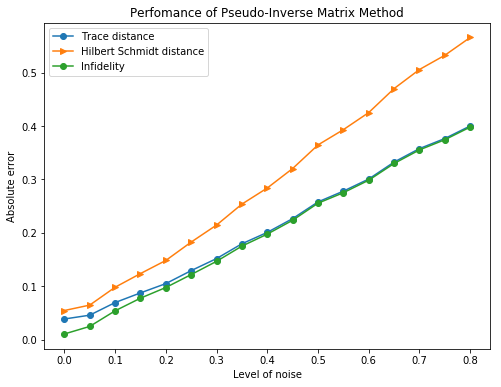

In [20]:
plt.figure(figsize=(8,6))
plt.plot(snr, norm_t_d, label = 'Trace distance', marker='o')
plt.plot(snr, norm_hs_d, label= 'Hilbert Schmidt distance', marker= '>')
plt.plot(snr, norm_if_d, label='Infidelity', marker='o')

plt.xlabel('Level of noise')
plt.ylabel('Absolute error')
plt.title('Perfomance of Pseudo-Inverse Matrix Method')
plt.legend()
plt.show()

### Semidefinite Programming

$F = \{x | Ax = b , f_i(x) \le 0\}$

1. $x_k$ is initial point. $x_k \in F$
2. Let's find $c = -\nabla f(x_k)$
3. Calculate $x_{k+1} = x_k + c\alpha$, such that $x_{k+1} \in F$ and $f_0(x_{k+1}) < f_0(x_k)$

$$
B(x,\mu) = f(x) - \lambda \sum \limits_i ln(f_i(x))
$$

$$
p_B = x + \frac{1}{\lambda} X^2(A^*\mu - b)
$$

The matrix Dantzig selector
$$
\hat{\rho}_{DS} = arg \min\limits_X \|X\|_{tr}\text{, s.t. }\|A^*(A(X) - y) \| < \lambda
$$
The Lasso matrix:
$$
\hat{\rho}_{Lasso} = arg \min\limits_X \frac{1}{2} \|A(X) - y\|^2_2 + \mu\|X\|_{tr}
$$

In [28]:
def ls_rho(mu, b, E):
    
    rho_ls = cp.Variable((2,2), complex = True)
    y = cp.Constant(b)
    S = cp.Constant(E)
    X = np.matrix([[0, 1], [1, 0]], dtype = np.complex64)
    Y = np.matrix([[0, -1j], [1j, 0]], dtype = complex)
    Z = np.matrix([[1, 0], [0, -1]], dtype = complex)
    I2 = np.eye(2)
    X_v = cp.Constant(X)
    Y_v = cp.Constant(Y)
    Z_v = cp.Constant(Z)
    I_v = cp.Constant(I2)

    constraints = [ cp.trace(rho_ls)==1
                     , rho_ls == rho_ls.H
                     , rho_ls >> 0
                  ]
    obj = cp.Minimize(
                      ( cp.abs( S[0][0]*cp.trace(I_v@rho_ls) + S[0][1]*cp.trace(X_v@rho_ls)
                              + S[0][2]*cp.trace(Y_v@rho_ls) + S[0][3]*cp.trace(Z_v@rho_ls) - y[0])**2 +
                        cp.abs( S[1][0]*cp.trace(I_v@rho_ls) + S[1][1]*cp.trace(X_v@rho_ls)
                              + S[1][2]*cp.trace(Y_v@rho_ls) + S[1][3]*cp.trace(Z_v@rho_ls) - y[1])**2 +
                        cp.abs( S[2][0]*cp.trace(I_v@rho_ls) + S[2][1]*cp.trace(X_v@rho_ls)
                              + S[2][2]*cp.trace(Y_v@rho_ls) + S[2][3]*cp.trace(Z_v@rho_ls) - y[2])**2 +
                        cp.abs( S[3][0]*cp.trace(I_v@rho_ls) + S[3][1]*cp.trace(X_v@rho_ls)
                              + S[3][2]*cp.trace(Y_v@rho_ls) + S[3][3]*cp.trace(Z_v@rho_ls) - y[3])**2  )/2 
                      + mu*norm.normNuc(rho_ls) )

    prob = cp.Problem(obj, constraints)
    prob.solve(solver = 'CVXOPT')
    rho_sdp_lasso = np.copy(rho_ls.value)
    return rho_sdp_lasso

In [29]:
import cvxpy as cp
import cvxpy.atoms.norm_nuc as norm
mu_l = 2**(-np.arange(-5, 10.0, 1))
norm_ls_ns_hs = []
norm_ls_ns_t = []
norm_ls_ns_if = []

sigm_ls_ns_hs = []
sigm_ls_ns_t = []
sigm_ls_ns_if = []

mu = 1.e-4
L_ns = (np.arange(1, 50, 5))
for ns in L_ns:
    rho_sdp_lasso = ls_rho(mu, b, E)
    zrs = np.zeros((2,2))
    n = 1
    N = 100000 # number of measurements (i.e. numer of copies of a system)
    hs_nm = []
    t_nm  = []
    if_nm = [] 
    for j in range(25):
        E = protocol('tetr', n)
        rho_vec = gen_state(n = n) # random state of system of n qubits
        N = 10000  # number of measurements (i.e. numer of copies of a system)
        b = measurements(E, rho_vec, N = N, noise =0.01*ns) # here we obtain probabilities of measurement outcomes
        rho_sdp_ls = ls_rho(mu, b, E)
        zrs = np.zeros((2,2))
        rho = pauli_dot(rho_vec)
        hs_nm.append(hs_norm(rho,rho_sdp_ls))
        t_nm.append(t_norm(rho,rho_sdp_ls))
        if_nm.append(if_norm(rho,rho_sdp_ls))
    #print(hs_nm, t_nm, if_nm)
    norm_ls_ns_hs.append(np.mean(hs_nm))
    norm_ls_ns_t.append(np.mean(t_nm))
    norm_ls_ns_if.append(np.mean(if_nm))
    
    sigm_ls_ns_hs.append(np.std(hs_nm))
    sigm_ls_ns_t.append(np.std(t_nm))
    sigm_ls_ns_if.append(np.std(if_nm))


C:\Users\1\Anaconda3\lib\site-packages\cvxpy\interface\numpy_interface\ndarray_interface.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return result.astype(numpy.float64)


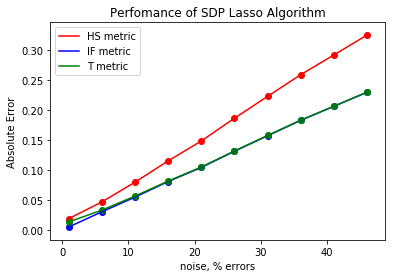

In [30]:
plt.plot(L_ns, norm_ls_ns_hs, 'r', label = 'HS metric')
plt.scatter(L_ns, norm_ls_ns_hs, c='r')
plt.scatter(L_ns, norm_ls_ns_if, c='b')
plt.scatter(L_ns, norm_ls_ns_t, c='g')
plt.plot(L_ns, norm_ls_ns_if, 'b', label = 'IF metric')
plt.plot(L_ns, norm_ls_ns_t, 'g', label = 'T metric')
plt.xlabel('noise, % errors')
plt.ylabel('Absolute Error')
plt.title('Perfomance of SDP Lasso Algorithm')
plt.legend()

In [31]:
def ds_rho(lam, b, S):
    rho_ds = cp.Variable((2,2), complex = True)
    
    y = cp.Constant(b)
    S = cp.Constant(E)
    X = np.matrix([[0, 1], [1, 0]], dtype = np.complex64)
    Y = np.matrix([[0, -1j], [1j, 0]], dtype = complex)
    Z = np.matrix([[1, 0], [0, -1]], dtype = complex)
    I2 = np.eye(2)
    X_v = cp.Constant(X)
    Y_v = cp.Constant(Y)
    Z_v = cp.Constant(Z)
    I_v = cp.Constant(I2)
    
    constraints = [   ( cp.abs( S[0][0]*cp.trace(I_v@rho_ds) + S[0][1]*cp.trace(X_v@rho_ds)
                              + S[0][2]*cp.trace(Y_v@rho_ds) + S[0][3]*cp.trace(Z_v@rho_ds) - y[0])**2 +
                        cp.abs( S[1][0]*cp.trace(I_v@rho_ds) + S[1][1]*cp.trace(X_v@rho_ds)
                              + S[1][2]*cp.trace(Y_v@rho_ds) + S[1][3]*cp.trace(Z_v@rho_ds) - y[1])**2 +
                        cp.abs( S[2][0]*cp.trace(I_v@rho_ds) + S[2][1]*cp.trace(X_v@rho_ds)
                              + S[2][2]*cp.trace(Y_v@rho_ds) + S[2][3]*cp.trace(Z_v@rho_ds) - y[2])**2 +
                        cp.abs( S[3][0]*cp.trace(I_v@rho_ds) + S[3][1]*cp.trace(X_v@rho_ds)
                              + S[3][2]*cp.trace(Y_v@rho_ds) + S[3][3]*cp.trace(Z_v@rho_ds) - y[3])**2  )  <= lam,
                      cp.trace(rho_ds) == 1,
                      rho_ds == rho_ds.H,
                      rho_ds >> 0
                    ]
    obj = cp.Minimize(norm.normNuc(rho_ds))

    prob = cp.Problem(obj, constraints)
    prob.solve(solver = 'CVXOPT')    
    rho_sdp_ds = np.copy(rho_ds.value)
    return rho_sdp_ds

In [32]:

lam_l = 2**(-np.arange(0, 20.0, 1))
norm_ds_hs = []
norm_ds_t = []
norm_ds_if = []
for lam in lam_l:
    rho_sdp_ds = ds_rho(lam, b, S)
    zrs = np.zeros((2,2))
    norm_ds_hs.append(hs_norm(rho,rho_sdp_ds)/hs_norm(rho,zrs))
    norm_ds_t.append(  t_norm(rho,rho_sdp_ds)/t_norm(rho,zrs))
    norm_ds_if.append(if_norm(rho,rho_sdp_ds)/if_norm(rho,zrs))

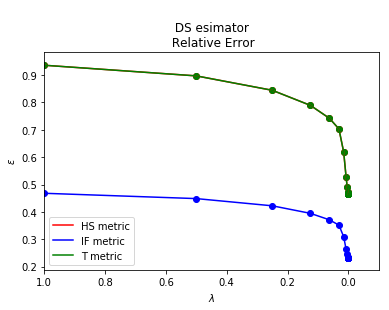

In [33]:
plt.plot(lam_l, norm_ds_hs, 'r', label = 'HS metric')
plt.scatter(lam_l, norm_ds_hs, c='r')
plt.scatter(lam_l, norm_ds_if, c='b')
plt.scatter(lam_l, norm_ds_t, c='g')
plt.plot(lam_l, norm_ds_if, 'b', label = 'IF metric')
plt.plot(lam_l, norm_ds_t, 'g', label = 'T metric')
plt.xlim(1.0, -0.1)
plt.xlabel('$\lambda$')
plt.ylabel('$\epsilon$')
plt.title(' \n DS esimator \n Relative Error')
plt.legend()

In [34]:
L_ns = (np.arange(1, 50, 5))
norm_ds_ns_hs = []
norm_ds_ns_t = []
norm_ds_ns_if = []

sigm_ds_ns_hs = []
sigm_ds_ns_t = []
sigm_ds_ns_if = []
for ns in L_ns:
    lam = 1.e-4
    n = 1
    N = 100000 # number of measurements (i.e. numer of copies of a system)
    hs_nm = []
    t_nm  = []
    if_nm = [] 
    for j in range(25):
        E = protocol('tetr', n)
        rho_vec = gen_state(n = n) # random state of system of n qubits
        N = 10000  # number of measurements (i.e. numer of copies of a system)
        b = measurements(E, rho_vec, N = N, noise =0.01*ns) # here we obtain probabilities of measurement outcomes
        rho_sdp_ds = ds_rho(lam, b, E)
        zrs = np.zeros((2,2))
        rho = pauli_dot(rho_vec)
        hs_nm.append(hs_norm(rho,rho_sdp_ds))
        t_nm.append(t_norm(rho,rho_sdp_ds))
        if_nm.append(if_norm(rho,rho_sdp_ds))
    #print(hs_nm, t_nm, if_nm)
    norm_ds_ns_hs.append(np.mean(hs_nm))
    norm_ds_ns_t.append(np.mean(t_nm))
    norm_ds_ns_if.append(np.mean(if_nm))
    
    sigm_ds_ns_hs.append(np.std(hs_nm))
    sigm_ds_ns_t.append(np.std(t_nm))
    sigm_ds_ns_if.append(np.std(if_nm))


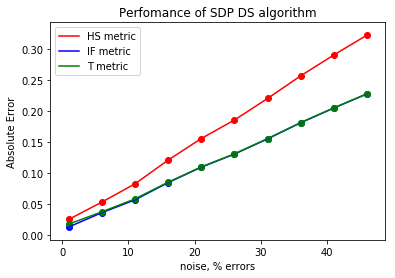

In [35]:
plt.plot(L_ns, norm_ds_ns_hs, 'r', label = 'HS metric')
plt.scatter(L_ns, norm_ds_ns_hs, c='r')
plt.scatter(L_ns, norm_ds_ns_if, c='b')
plt.scatter(L_ns, norm_ds_ns_t, c='g')
plt.plot(L_ns, norm_ds_ns_if, 'b', label = 'IF metric')
plt.plot(L_ns, norm_ds_ns_t, 'g', label = 'T metric')
plt.xlabel('noise, % errors')
plt.ylabel('Absolute Error')
plt.title('Perfomance of SDP DS algorithm')
plt.legend()

### Gradient descent

We will maximize likelihood function using gradient descent approach. Start with initial guess $\rho_0 = I/2$ (i.e. totally mixed state). Then, every iteration step we choose a direction of the fastest increasing of likelihood function.

In [21]:
def operator_from_vec(vec):
    vec = np.array(vec).reshape(-1)
    X = np.matrix([[0, 1], [1, 0]], dtype = complex)
    Y = np.matrix([[0, -1j], [1j, 0]], dtype = complex)
    Z = np.matrix([[1, 0], [0, -1]], dtype = complex)
    I2 = np.eye(2)
    s = np.array([I2,X,Y,Z])
    S = s

    # define number of qubits:
    k = int(np.log2(np.sqrt(len(vec))))
    
    for i in range(k-1):
        S =  np.kron(S,s)
        
#     rho = S[0]*vector[0]/(2**k)
    opert = np.zeros(S[0].shape)
    for i in range(S.shape[0]):
        opert = opert + S[i] * vec[i]
    
    return opert


def gradient(S, f, rho_vec, eps):
    """
    optimization of ML function via gradient descent method
    """
    rho = pauli_dot(rho_vec)
    
    def R(rho):
        S0 = operator_from_vec(S[0])
        p0 = np.trace(S0 @ rho)
        r = S0 * f[0]/p0
        for j in range(1,E.shape[0]):
            Sj = operator_from_vec(S[j])
            pj =  np.trace(Sj@rho)
            r = r + (Sj * f[j]/pj)
        return r
    
    def LLH(rho):
        return np.trace(R(rho) @ rho)
    
    def rho_next(eps, Rk):
        I = np.eye(rho.shape[0])
        numer = (I+eps/2*(Rk - I)) @ rho @ (I+eps/2*(Rk+I))
        denom = np.trace(numer)
        return numer/denom

    b = 1 # for setup of eps1, eps2
    LLH_c = LLH(rho)
    
    conv_t = []
    conv_hs = []
    conv_if = []
    zero_el = np.zeros((2,2))
    
    for k in range(1000):
        Rk = R(rho)
        eps_ar = np.array([0, np.random.rand(), np.random.rand()])*b
        
        LLH_1 = LLH(rho_next(eps_ar[1], Rk))
        LLH_2 = LLH(rho_next(eps_ar[2], Rk))        
        
        eps_c = np.argmin([LLH_c, LLH_1, LLH_2])
        
        rho_n = rho_next(eps_c, Rk)
        LLH_c = LLH(rho)
        
        # check if algorithm still are improoving current guess
        if (t_norm(Rk@rho,rho) + hs_norm(Rk@rho,rho) + if_norm(Rk@rho, rho)) < eps:
            break
        
        if k>1:
            conv_t.append(t_norm(rho, rho_n)/t_norm(rho, zero_el))
            conv_hs.append(hs_norm(rho, rho_n)/hs_norm(rho, zero_el))
            conv_if.append(if_norm(rho, rho_n)/if_norm(rho, zero_el))
        
        LLH_c = LLH(rho_n)
        rho = rho_n
        
    
    return rho, conv_t, conv_hs, conv_if

In [22]:
n = 1 
E = protocol('tetr', n)
S = np.matrix(E)

rho_vec = gen_state(n = n) # random state of system of n qubits

N = 1000
snr = np.arange(0,0.85,0.05) # noise level


hist_t = []
hist_hs = []
hist_if = []
rho_est_ar = []

for noise in snr:
    b = measurements(E, rho_vec, N = N, noise=noise)
    
    rho_est, h_t, h_hs, h_if = gradient(S, f = b, rho_vec=[1,0,0,0], eps = 1e-4)
    
    rho_est_ar.append(rho_est)
    hist_t.append(h_t)
    hist_hs.append(h_hs)
    hist_if.append(h_if)
    


In [23]:
ksi_t = []
ksi_hs = []
ksi_if = []
zero_el = np.zeros((2,2))
rho_true = pauli_dot(rho_vec)

for i in range(len(rho_est_ar)):
#     ksi_t.append( t_norm(rho_true, rho_est_ar[i])/t_norm(rho_true, zero_el))
#     ksi_hs.append( hs_norm(rho_true, rho_est_ar[i])/hs_norm(rho_true, zero_el))
#     ksi_if.append( if_norm(rho_true, rho_est_ar[i])/if_norm(rho_true, zero_el))
    
    ksi_t.append( t_norm(rho_true, rho_est_ar[i]))
    ksi_hs.append( hs_norm(rho_true, rho_est_ar[i]))
    ksi_if.append( if_norm(rho_true, rho_est_ar[i]))

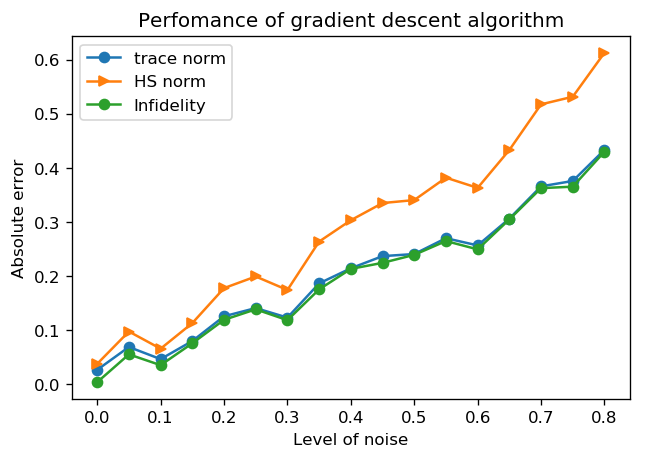

In [24]:
plt.figure(dpi=120)
plt.plot(snr, np.real(ksi_t), label = 'trace norm', marker='o')
plt.plot(snr, np.real(ksi_hs), label = 'HS norm', marker= '>')
plt.plot(snr, np.real(ksi_if), label = 'Infidelity', marker='o')

plt.xlabel('Level of noise')
plt.ylabel('Absolute error')
plt.title('Perfomance of gradient descent algorithm')
plt.legend()
plt.show()

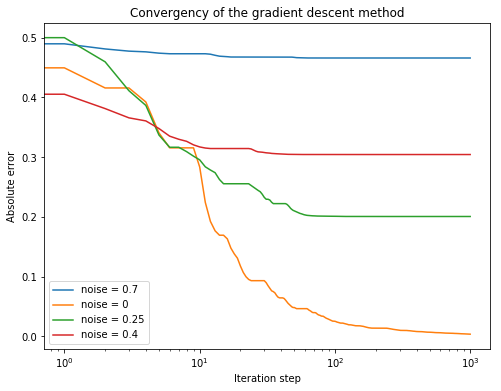

In [40]:
plt.figure(figsize=(8,6))
plt.semilogx(hist_if[14], label = 'noise = 0.7')
plt.semilogx(hist_if[0], label = 'noise = 0')
plt.semilogx(hist_if[5], label = 'noise = 0.25')
plt.semilogx(hist_if[8], label = 'noise = 0.4')
plt.legend(loc = 3)
plt.xlabel('Iteration step')
plt.ylabel('Absolute error')
plt.title('Convergency of the gradient descent method')
plt.savefig('conv')
plt.show()

### Comparison of different algorithms

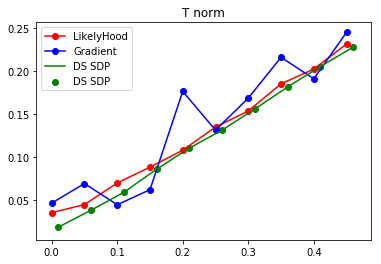

In [43]:
plt.plot(snr[:10], norm_t_d[:10], 'r', label = 'LikelyHood', marker='o')
plt.plot(snr[:10], np.real(ksi_t)[:10], 'b', label = 'Gradient', marker='o')
plt.scatter(L_ns/100, norm_ds_ns_t, c = 'g', label = 'DS SDP')
plt.plot(L_ns/100, norm_ds_ns_t, 'g', label = 'DS SDP')
plt.title('T norm')
plt.legend()

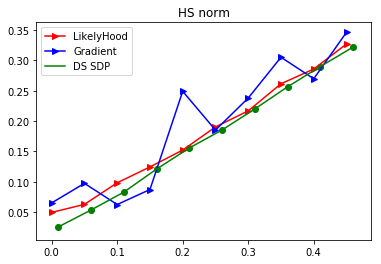

In [44]:
plt.plot(snr[:10], norm_hs_d[:10], 'r', label= 'LikelyHood', marker= '>')
plt.plot(snr[:10], np.real(ksi_hs)[:10], 'b', label = 'Gradient', marker= '>')
plt.plot(L_ns/100, norm_ds_ns_hs, 'g', label = 'DS SDP')
plt.scatter(L_ns/100, norm_ds_ns_hs, c='g')
plt.title('HS norm')
plt.legend()

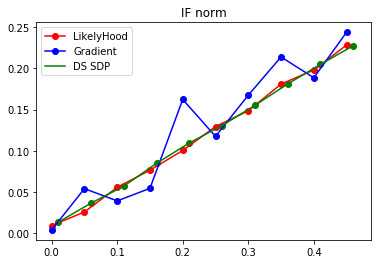

In [45]:
plt.plot(snr[:10], norm_if_d[:10], 'r',label='LikelyHood', marker='o')
plt.plot(snr[:10], np.real(ksi_if)[:10], 'b',label = 'Gradient', marker='o')
plt.scatter(L_ns/100, norm_ds_ns_if, c='g')
plt.plot(L_ns/100, norm_ds_ns_if, 'g', label = 'DS SDP')
plt.title('IF norm')
plt.legend()